# Overview over different applications of the new pairinteraction software

We released an alpha version of the new pairinteraction software on test.pypi.org. It can be installed with the following command on Linux, MacOS 13+, and Windows:

`pip install --only-binary pairinteraction --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ pairinteraction`

The new pairinteraction software allows for calculation Rydberg pair potentials, optionally considering electric and magnetic fields in arbitrary directions. The software is written so that it works equally well for atoms with a single valence electron and atoms which require multi-channel quantum defect theory. To achieve a high performance, the backend of the software is written in C++ and wrapped with nanobind, providing a Python interface. The construction of Hamiltonians is accelerated by using pre-calculated matrix elements, which are stored in database tables. These tables are automatically downloaded from GitHub when needed \[[1](https://github.com/pairinteraction/database-sqdt),[2](https://github.com/pairinteraction/database-mqdt)\]. Once the tables are downloaded, they are cached locally and the software can be used without an internet connection.

Since the software is still under development, we would greatly appreciate your feedback. If you encounter any issues or if you have wishes for additional features, please let us know.

Over the next few months, we plan to add the following functionalities:

* Consideration of more symmetries. The old version of pairinteraction made full use of symmetries to reduce the size of the Hamiltonian. We have the same goal for the new version.

* Using Intel's MKL library for the diagonalization of the Hamiltonians. While the diagonalization of the Hamiltonians is already quite fast thanks to a parallelization of the diagonalization in C++, we we can further improve the performance by using Intel's MKL library.

* Adding a more high-level Python interface. Currently, the Python interface is quite low-level. While this allows for a lot of flexibility and shows how the software works, a more high-level interface could make it easier to run the most common calculations, reducing the amount of code that has to be written by the user.

* Adding a graphical user interface. We plan to add a graphical user interface, similarly to the one of the old pairinteraction software.

* Improving the documentation. At the moment, except for example notebooks, the documentation is basically non-existent. We plan to add a proper documentation of the Python API.

In addition to this Jupyter notebook, further examples are [available on GitHub](https://github.com/johannes-moegerle/example_notebooks).

## 1. Prerequisites

Before running the example code in this notebook, you have to execute the code cell below to import the necessary libraries and initialize pairinteraction's database that contains pre-calculated atomic states and matrix elements. By setting `download_missing=True`, database tables are automatically downloaded from GitHub when needed.

In [1]:
%env SPDLOG_LEVEL=error

import matplotlib.pyplot as plt
import numpy as np

import pairinteraction.backend.float as pi

pi.initialize_global_database(download_missing=True)

env: SPDLOG_LEVEL=error


## 2. How to use the software

### Choosing a backend

The pairinteraction Python library offers multiple backends, each with a different numerical precision: `float`, `double`, `complexfloat`, and `complexdouble` (complex-valued data types are only needed if a Hamiltonian contains complex elements as it is the case for fields pointing along the y-direction). In this notebook, we are using the `float` backend. For slower but more accurate calculations, you can import the `double` backend in the code cell above. Changing the backend might require restarting the kernel.

### Modelling a single atom

The library is structured around Python classes that can be used to model systems of Rydberg atoms. For modelling a single atom, the following classes are available:

* `KetAtom`: State of a single Rydberg atom, constructed from quantum numbers (if the specified quantum numbers do not match any of the pre-calculated states precisely, the closest state is used). You can display information about a state by using Python's `print` function on a `KetAtom` object.

* `BasisAtom`: Basis of the single-atom Hilbert space, constructed from ranges of quantum numbers. The basis is initialized as the canonical basis of the Hilbert space, i.e., the basis is made up of basis vectors that each have a single non-zero element corresponding to a particular `KetAtom` state.

* `SystemAtom`: System of a single Rydberg atom, constructed from a `BasisAtom` and the electric and magnetic fields acting on the atom. The class provides access to the atom's Hamiltonian.

### Modelling two atoms

Two single-atom systems can be combined to model a pair of atoms using the following classes:

* `BasisPair`: Basis of a pair of atoms, constructed from two `SystemAtom` objects. For constructing the basis, the eigenstates of the Hamiltonians of the two atoms are used. The basis is initialized as the canonical basis where each basis vector has a single non-zero element corresponding to a tensor product of the eigenstates. The energy of the state, that is described by such a basis vector, is the sum of the eigenenergies. To keep the basis size manageable, you can truncate it by specifying an energy range.

* `SystemPair`: System of a pair of atoms, constructed from a `BasisPair` and the interaction between the atoms. This class provides access to the two-atom Hamiltonian.

### Diagonalizing Hamiltonians

For plotting Stark maps / Zeeman maps / pair potentials, the eigenvalues of Hamiltonians are needed. You can diagonalize multiple Hamiltonians in parallel by passing a list of systems to the `diagonalize` function. The parallelization is implemented in C++, ensuring fast diagonalization. For example, here is how you can compute eigenvalues for different electric field strengths:

In [2]:
basis = pi.BasisAtom("Rb", n=(57, 63), l=(0, 3))
systems = [pi.SystemAtom(basis).set_electric_field([0, 0, ez], unit="V/cm") for ez in [0, 0.1, 0.2, 0.3]]
pi.diagonalize(systems, diagonalizer="Eigen")
eigenvalues = [system.get_eigenvalues(unit="GHz") for system in systems]

Depending on the operation system, different diagonalizers are available. You can try to use Lapacke by setting `diagonalizer="Lapacke"`, what can be faster than the Eigen diagonalizer.

### Unit conversions

Many methods accept a `unit` parameter, such as `set_electric_field` and `get_eigenvalues`. This parameter allows you to chose in which units you want to set or obtain values. The pairinteraction software automatically performs the required unit conversions.

### Code completion

The Python API of pairinteraction is designed so that code completion should work in Python development environments. For example, if you type `pi.BasisAtom(` and then press `Ctrl+Space` in Visual Studio Code, you should see a list of available arguments for the `BasisAtom` constructor. If code completion does not work, please let us know.

### Logging

The pairinteraction software prints log messages to the console. You can control the verbosity of the log messages by setting the `SPDLOG_LEVEL` environment variable to one of the following values: `debug`, `info`, `warn`, `error`. This can be done by adding, for example, `%env SPDLOG_LEVEL=error%env SPDLOG_LEVEL=error` at the beginning of a Juptyer notebook cell (note that changing the log level requires restarting the kernel). Note that under Windows, the log messages are not shown in a Jupyter notebook, but only in a console.

### Self testing

The pairinteraction software includes self tests that checks if the pairinteraction python module is working correctly. You can run the tests as follows:

In [ ]:
from pairinteraction import run_module_tests

assert run_module_tests(download_missing=True) == 0

## 3. Basic example

The following example shows how to use the Python API to calculate a pair potential for rubidium.

Number of basis states of the pair system: 172


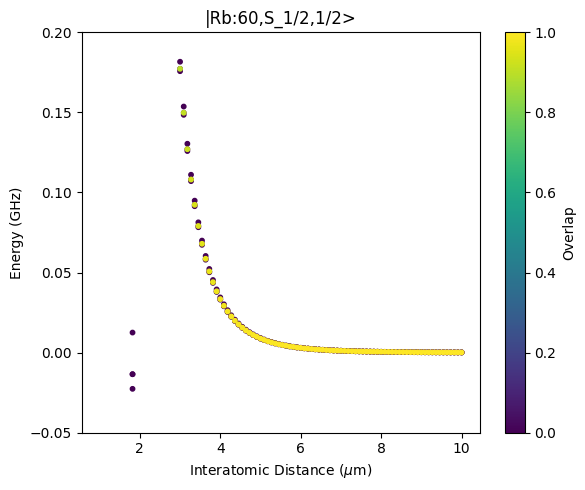

In [4]:
distances = np.linspace(1, 10, 100)

ket = pi.KetAtom("Rb", n=60, l=0, j=0.5, m=0.5)
pair_energy = 2 * ket.get_energy(unit="GHz")

# Single-atom system
basis = pi.BasisAtom("Rb", n=(ket.n - 3, ket.n + 3), l=(0, 3))
system = pi.SystemAtom(basis)

# Pair systems for different interatomic distances
pair_basis = pi.BasisPair([system, system], energy=(pair_energy - 3, pair_energy + 3), energy_unit="GHz")
pair_systems = [pi.SystemPair(pair_basis).set_distance(d, unit="micrometer") for d in distances]
print(f"Number of basis states of the pair system: {pair_basis.number_of_states}", flush=True)

# Diagonalize the systems in parallel and get the eigenvalues and overlaps
pi.diagonalize(pair_systems, diagonalizer="Eigen")
eigenvalues = np.array([system.get_eigenvalues(unit="GHz") for system in pair_systems])
overlaps = np.array([system.get_eigenbasis().get_overlaps_with_product_state(ket, ket) for system in pair_systems])
distances = np.repeat(distances, eigenvalues.shape[1])

# Sort the data so that the pair potential with the largest overlap is on top of all other pair potentials
sorter = np.argsort(overlaps.flat)
overlaps = overlaps.flat[sorter]
eigenvalues = eigenvalues.flat[sorter]
distances = distances[sorter]

# Plot the pair potentials
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.set_title(f"|{ket}>")
scat = ax.scatter(distances, eigenvalues - pair_energy, c=overlaps, s=10, vmin=0, vmax=1)
fig.colorbar(scat, label="Overlap")
ax.set_ylim(-0.05, 0.2)
ax.set_xlabel(r"Interatomic Distance ($\mu$m)")
ax.set_ylabel("Energy (GHz)")
fig.tight_layout()
plt.show()

## 4. Making use of symmetries

Because in the previous example, the interatomic axis was aligned with the quantization axis, the *total quantum number m* is conserved. In addition, the system is symmetric under permutation and inversion. If both symmetries are present, the *product of the parities of the two atoms* is conserved as well. In the following, we adapted the previous example to make use of these symmetries. For future versions of the pairinteraction software, we plan to support additional symmetries.

Number of basis states of the pair system: 19


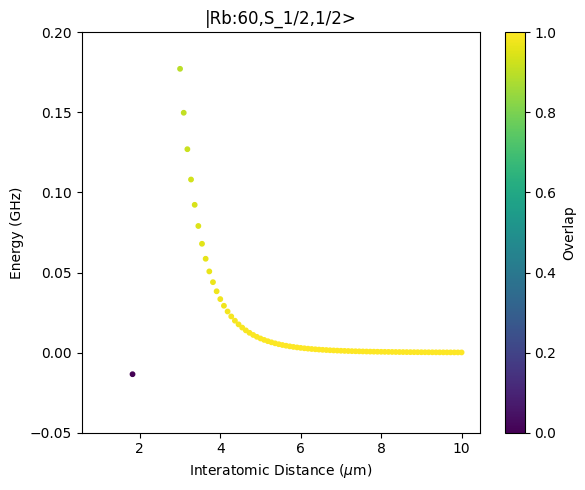

In [5]:
distances = np.linspace(1, 10, 100)

ket = pi.KetAtom("Rb", n=60, l=0, j=0.5, m=0.5)
pair_energy = 2 * ket.get_energy(unit="GHz")

# Single-atom system
basis = pi.BasisAtom("Rb", n=(ket.n - 3, ket.n + 3), l=(0, 3))
system = pi.SystemAtom(basis)

# Pair systems for different interatomic distances
pair_basis = pi.BasisPair(
    [system, system],
    energy=(pair_energy - 3, pair_energy + 3),
    energy_unit="GHz",
    m=(1.0, 1.0),  # Conserved because of interatomic axis along quantization axis
    product_of_parities="EVEN",  # Conserved because of inversion + permutation symmetry
)
pair_systems = [pi.SystemPair(pair_basis).set_distance(d, unit="micrometer") for d in distances]
print(f"Number of basis states of the pair system: {pair_basis.number_of_states}", flush=True)

# Diagonalize the systems in parallel and get the eigenvalues and overlaps
pi.diagonalize(pair_systems, diagonalizer="Eigen")
eigenvalues = np.array([system.get_eigenvalues(unit="GHz") for system in pair_systems])
overlaps = np.array([system.get_eigenbasis().get_overlaps_with_product_state(ket, ket) for system in pair_systems])
distances = np.repeat(distances, eigenvalues.shape[1])

# Sort the data so that the pair potential with the largest overlap is on top of all other pair potentials
sorter = np.argsort(overlaps.flat)
overlaps = overlaps.flat[sorter]
eigenvalues = eigenvalues.flat[sorter]
distances = distances[sorter]

# Plot the pair potentials
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.set_title(f"|{ket}>")
scat = ax.scatter(distances, eigenvalues - pair_energy, c=overlaps, s=10, vmin=0, vmax=1)
fig.colorbar(scat, label="Overlap")
ax.set_ylim(-0.05, 0.2)
ax.set_xlabel(r"Interatomic Distance ($\mu$m)")
ax.set_ylabel("Energy (GHz)")
fig.tight_layout()
plt.show()

## 5. Adding external fields

We can also add external electric and magnetic fields to the calculation. We let the fields point along the quantization axis so that the total quantum number m is still conserved.

Number of basis states of the pair system: 33


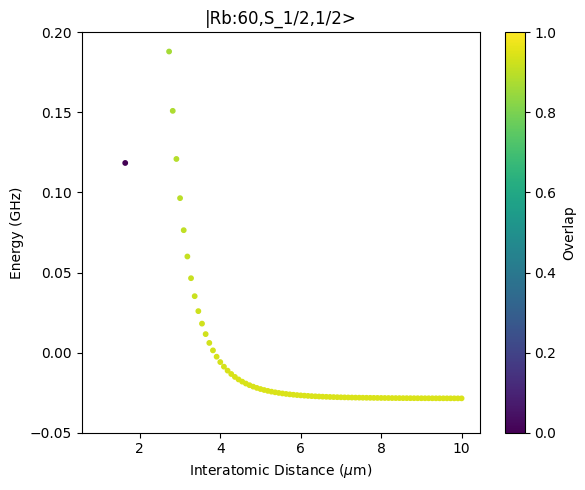

In [6]:
distances = np.linspace(1, 10, 100)
efield = [0, 0, 0.8]
bfield = [0, 0, 30]

ket = pi.KetAtom("Rb", n=60, l=0, j=0.5, m=0.5)
pair_energy = 2 * ket.get_energy(unit="GHz")

# Single-atom system
basis = pi.BasisAtom("Rb", n=(ket.n - 3, ket.n + 3), l=(0, 3))
system = (
    pi.SystemAtom(basis)
    .set_electric_field(efield, unit="V/cm")
    .set_magnetic_field(bfield, unit="G")
    .enable_diamagnetism(True)
)
system.diagonalize(diagonalizer="Eigen")  # The system must be diagonalized before using it to construct pair systems

# Pair systems for different interatomic distances
pair_basis = pi.BasisPair(
    [system, system],
    energy=(pair_energy - 3, pair_energy + 3),
    energy_unit="GHz",
    m=(1.0, 1.0),  # Conserved because of interatomic axis along quantization axis
)
pair_systems = [pi.SystemPair(pair_basis).set_distance(d, unit="micrometer") for d in distances]
print(f"Number of basis states of the pair system: {pair_basis.number_of_states}", flush=True)

# Diagonalize the systems in parallel and get the eigenvalues and overlaps
pi.diagonalize(pair_systems, diagonalizer="Eigen")
eigenvalues = np.array([system.get_eigenvalues(unit="GHz") for system in pair_systems])
overlaps = np.array([system.get_eigenbasis().get_overlaps_with_product_state(ket, ket) for system in pair_systems])
distances = np.repeat(distances, eigenvalues.shape[1])

# Sort the data so that the pair potential with the largest overlap is on top of all other pair potentials
sorter = np.argsort(overlaps.flat)
overlaps = overlaps.flat[sorter]
eigenvalues = eigenvalues.flat[sorter]
distances = distances[sorter]

# Plot the pair potentials
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.set_title(f"|{ket}>")
scat = ax.scatter(distances, eigenvalues - pair_energy, c=overlaps, s=10, vmin=0, vmax=1)
fig.colorbar(scat, label="Overlap")
ax.set_ylim(-0.05, 0.2)
ax.set_xlabel(r"Interatomic Distance ($\mu$m)")
ax.set_ylabel("Energy (GHz)")
fig.tight_layout()
plt.show()

## 6. Dipole-quadrupole and quadrupole-quadrupole interaction

By default, the pairinteraction software includes dipole-dipole interaction. We can consider the multipole expansion up to dipole-quadrupole or quadrupole-quadrupole by setting the order of the interaction to 3 or 4, respectively.

Number of basis states of the pair system: 476


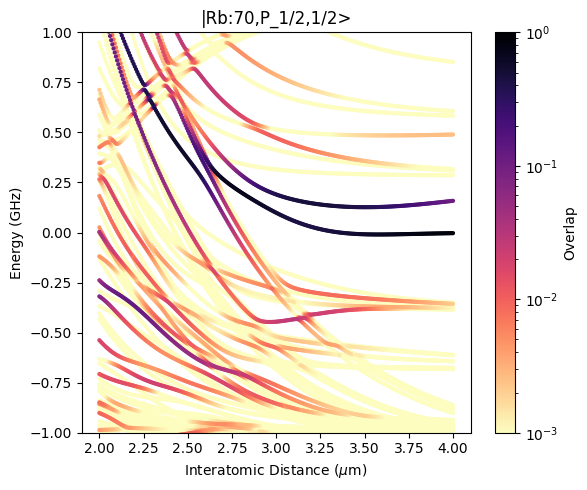

In [7]:
order = 5  # 3: dipole-dipole, 4: up to dipole-quadrupole, 5: up to quadrupole-quadrupole

distances = np.linspace(2, 4, 300)

ket = pi.KetAtom("Rb", n=70, l=1, j=0.5, m=0.5)
pair_energy = 2 * ket.get_energy(unit="GHz")

# Single-atom system
basis = pi.BasisAtom("Rb", n=(ket.n - 3, ket.n + 3), l=(0, 4))
system = pi.SystemAtom(basis)

# Pair systems for different interatomic distances
pair_basis = pi.BasisPair(
    [system, system],
    energy=(pair_energy - 4, pair_energy + 4),
    energy_unit="GHz",
    m=(2 * ket.m, 2 * ket.m),  # Conserved because of interatomic axis along quantization axis
)
pair_systems = [pi.SystemPair(pair_basis).set_order(order).set_distance(d, unit="micrometer") for d in distances]
print(f"Number of basis states of the pair system: {pair_basis.number_of_states}", flush=True)

# Diagonalize the systems in parallel and get the eigenvalues and overlaps
pi.diagonalize(pair_systems, diagonalizer="Eigen")
eigenvalues = np.array([system.get_eigenvalues(unit="GHz") for system in pair_systems])
overlaps = np.array([system.get_eigenbasis().get_overlaps_with_product_state(ket, ket) for system in pair_systems])
distances = np.repeat(distances, eigenvalues.shape[1])

# Sort the data so that the pair potential with the largest overlap is on top of all other pair potentials
sorter = np.argsort(overlaps.flat)
overlaps = overlaps.flat[sorter]
eigenvalues = eigenvalues.flat[sorter]
distances = distances[sorter]

# Plot the pair potentials
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.set_title(f"|{ket}>")
scat = ax.scatter(distances, eigenvalues - pair_energy, c=overlaps, s=4, vmin=1e-3, vmax=1, norm="log", cmap="magma_r")
fig.colorbar(scat, label="Overlap")
ax.set_ylim(-1, 1)
ax.set_xlabel(r"Interatomic Distance ($\mu$m)")
ax.set_ylabel("Energy (GHz)")
fig.tight_layout()
plt.show()

## 7. Comparison to literature results for Yb171 and Yb174

The new version of pairinteraction supports atomic species with two valence electrons such as Yb171 and Yb174, using multi-channel quantum defect theory. To ensure the correctness of our calculations, we reproduce findings of the publication [M. Peper et al., *Spectroscopy and modeling of 171Yb Rydberg states for high-fidelity two-qubit gates"*, 2024](https://arxiv.org/abs/2406.01482). In this publication, the authors carefully benchmarked their results against experimental data. Thus, by reproducing their results, we can be confident that our software provides accurate predictions as well.

As a first check, we reproduce the Zeeman map for Yb174 that is shown in Fig. 13 of the publication. The Zeeman map takes into account diamagnetism.

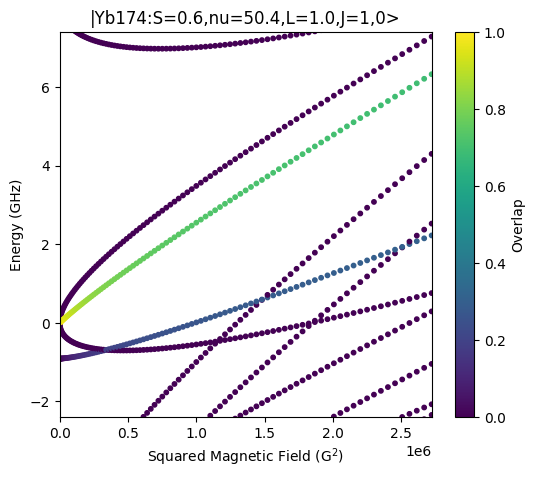

In [8]:
# Get the state of interest
ket = pi.KetAtom("Yb174_mqdt", nu=50, s=1, l=1, j=1, m=0)
energy_in_ghz = ket.get_energy(unit="GHz")

# Construct a basis around the state
basis = pi.BasisAtom("Yb174_mqdt", nu=(ket.nu - 3, ket.nu + 3), j=(0, 2))

# Construct and diagonalize systems for different magnetic fields
list_bfield_in_gauss = np.linspace(0, 1650, 100)
list_system = [
    pi.SystemAtom(basis).set_magnetic_field([0, 0, b], unit="G").enable_diamagnetism(True) for b in list_bfield_in_gauss
]
pi.diagonalize(list_system, diagonalizer="Eigen")

# Get eigenvalues and overlaps
list_eigenvalues = np.array([system.get_eigenvalues(unit="GHz") for system in list_system])
list_overlap = np.array([system.get_eigenbasis().get_overlaps(ket) for system in list_system])

# Plot the Zeeman map
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.set_title(f"|{ket}>")
scat = ax.scatter(
    np.repeat(list_bfield_in_gauss, list_eigenvalues.shape[1]) ** 2,
    list_eigenvalues - energy_in_ghz,
    c=list_overlap,
    s=10,
    vmin=0,
    vmax=1,
)
fig.colorbar(scat, label="Overlap")
ax.set_xlim(0, list_bfield_in_gauss[-1] ** 2)
ax.set_ylim(-2.4, 7.4)
ax.set_xlabel(r"Squared Magnetic Field (G$^2$)")
ax.set_ylabel("Energy (GHz)")
plt.show()

As a second check, we reproduce the pair potentials for Yb171 that are displayed in Fig. 7a of the publication. The pair potentials are calculated for a magnetic field pointing along the z-axis and the interatomic axis pointing along the x-axis. Because this arrangement breaks rotational symmetry, the total magnetic quantum number is not conserved and two-atom Hilbert space is rather large. Therefore, the calculation of the pair potentials takes some minutes. We hope to improve the performance by using Intel's MKL library for the diagonalization in the future.

env: SPDLOG_LEVEL=error
Pair basis size: 4052


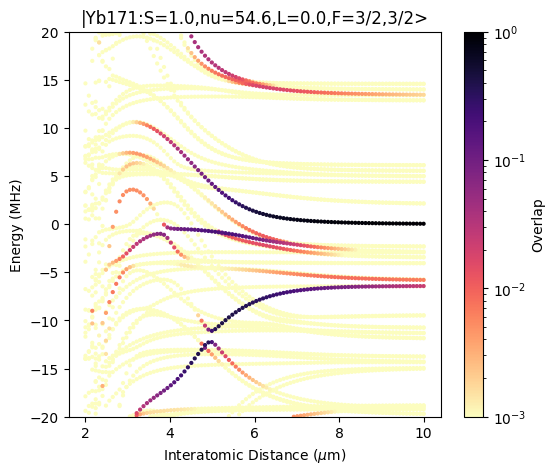

In [ ]:
if False:  # Run this cell only if you are okay with waiting for some minutes
    # Get the state of interest
    ket = pi.KetAtom("Yb171_mqdt", nu=54.56, l=0, f=3 / 2, m=3 / 2)

    # Construct a basis around the state
    basis = pi.BasisAtom("Yb171_mqdt", nu=(ket.nu - 2, ket.nu + 2), f=(0.5, 2.5))

    # Construct and diagonalize a system for a single atom
    system = (
        pi.SystemAtom(basis)
        .set_magnetic_field([0, 0, 5.03], unit="G")
        .enable_diamagnetism(True)
        .diagonalize(diagonalizer="Eigen")
    )

    idx = np.argmax(system.get_eigenbasis().get_overlaps(ket))
    pair_energy_shifted = 2 * system.get_eigenvalues(unit="MHz")[idx]

    # Construct a basis for a pair of atoms
    basis_pair = pi.BasisPair(
        [system, system], energy=(pair_energy_shifted - 4e3, pair_energy_shifted + 4e3), energy_unit="MHz"
    )
    print(f"Pair basis size: {basis_pair.number_of_states}", flush=True)

    # Construct and diagonalize systems for different interatomic distances
    list_distances = np.linspace(2, 10, 100)
    list_system = [pi.SystemPair(basis_pair).set_distance_vector([d, 0, 0], unit="um") for d in list_distances]
    pi.diagonalize(
        list_system,
        diagonalizer="Eigen",
        energy_range=(pair_energy_shifted - 20, pair_energy_shifted + 20),
        energy_unit="MHz",
    )

    # Get eigenvalues and overlaps
    list_eigenvalues = [system.get_eigenvalues(unit="MHz") for system in list_system]
    list_overlap = [system.get_eigenbasis().get_overlaps_with_product_state(ket, ket) for system in list_system]
    list_distances = [d * np.ones_like(e) for d, e in zip(list_distances, list_eigenvalues)]

    # Plot the pair potential
    list_eigenvalues = np.hstack(list_eigenvalues)
    list_overlap = np.hstack(list_overlap)
    list_distances = np.hstack(list_distances)

    sorter = np.argsort(list_overlap)
    list_distances = list_distances[sorter]
    list_eigenvalues = list_eigenvalues[sorter]
    list_overlap = list_overlap[sorter]

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    ax.set_title(f"|{ket}>")
    scat = ax.scatter(
        list_distances,
        list_eigenvalues - pair_energy_shifted,
        c=list_overlap,
        s=4,
        vmin=1e-3,
        vmax=1,
        norm="log",
        cmap="magma_r",
    )
    fig.colorbar(scat, label="Overlap")
    ax.set_xlim(2, 10)
    ax.set_ylim(-20, 20)
    ax.set_xlabel(r"Interatomic Distance ($\mu$m)")
    ax.set_ylabel("Energy (MHz)")
    plt.show()